# Which authors tends to be more collaborative with external institutions?

In this script we will try to answer the question of which authors tends to be more collaborative with EUTOPIA institutions. 

In [5]:

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import seaborn as sns
from box import Box
from google.cloud import bigquery
from scipy.stats import percentileofscore

In [6]:
# -------------------- GLOBAL VARIABLES --------------------
PATH_TO_CONFIG_FILE = '../config.yml'

# -------------------- LOAD CONFIGURATION --------------------
# Load the configuration file
config = Box.from_yaml(filename=PATH_TO_CONFIG_FILE)
# Initialize a BigQuery client
client = bigquery.Client(project=config.GCP.PROJECT_ID)
# Set the BigQuery dataset schema
schema = config.GCP.READ_SCHEMA
# Set numpy random seed
np.random.seed(config.RANDOM_SEED)

## Data preparation
After loading the general configuration, we will prepare the data from BigQuery:
1. Count the number of publications and external collaborations for each author. 
2. Calculate the proportion of external collaborations for each author.
3. Filter out authors from non-EUTOPIA institutions and authors with zero publications or zero collaborations.
4. Clip the collaboration rate to avoid issues with the Beta distribution in the Bayesian model.

In [7]:
# Read data via BigQuery
query = f"""
SELECT
  AUTHOR_SID,
  COUNT(ARTICLE_SID) AS PUBLICATIONS,
  COUNT(DISTINCT IF(IS_EXTERNAL_COLLABORATION, ARTICLE_SID, NULL)) AS EXTERNAL_COLLABORATIONS
FROM
    {schema}.FCT_COLLABORATION
WHERE INSTITUTION_SID <> 'n/a'
GROUP BY AUTHOR_SID
"""
df = client.query(query).to_dataframe()

# We need to calculate the proportion of external collaborations for each author
df['COLLABORATION_RATE'] = df['EXTERNAL_COLLABORATIONS'] / df['PUBLICATIONS']

# Handle zero publications or zero collaborations to avoid issues with the Beta distribution
df = df[(df['PUBLICATIONS'] > 0) & (df['EXTERNAL_COLLABORATIONS'] >= 0)]
# Filter out outliers with extremely low number of publications
df = df[(df['PUBLICATIONS'] >= 10)]
# Clip the collaboration rate to avoid issues with the Beta distribution
df['COLLABORATION_RATE'] = np.clip(a=df['COLLABORATION_RATE'],
                                   a_min=1e-6,
                                   a_max=1 - 1e-6)

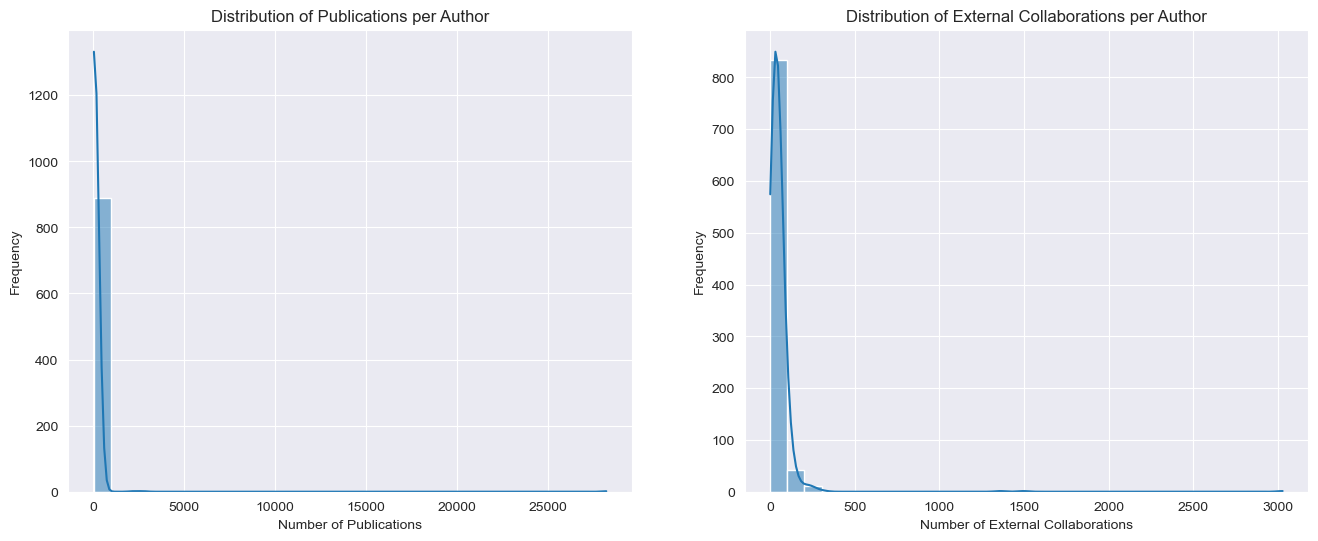

In [8]:
# Visualize the distributions of publications and external collaborations in side-by-side histograms
# 1. Distribution of Publications per Author
fig, (plt1, plt2) = plt.subplots(1, 2, figsize=(16, 6))
sns.histplot(df[df['PUBLICATIONS'] > 50]['PUBLICATIONS'], bins=30, kde=True, ax=plt1)
plt1.set_title('Distribution of Publications per Author')
plt1.set_xlabel('Number of Publications')
plt1.set_ylabel('Frequency')
# 2. Distribution of External Collaborations per Author
sns.histplot(df[df['PUBLICATIONS'] > 50]['EXTERNAL_COLLABORATIONS'], bins=30, kde=True, ax=plt2)
plt2.set_title('Distribution of External Collaborations per Author')
plt2.set_xlabel('Number of External Collaborations')
plt2.set_ylabel('Frequency')
plt.show()

## Bayesian model

We will define a simple Bayesian model to describe the collaboration rate of authors with EUTOPIA institutions. Using Bayesian inference, we estimate the parameters (`alpha` and `beta`) of a Beta distribution that best describe the observed collaboration rates of authors.

**Prior:** We use HalfNormal priors for the parameters `alpha` and `beta`. The HalfNormal distribution is a suitable choice for positive real-valued parameters because it only allows positive values. We set the standard deviation of the HalfNormal priors to 10, which is a relatively uninformative prior and hence not too constraining.

**Data likelihood:** We model the observed collaboration rates as a Beta distribution with parameters `alpha` and `beta`. Beta distribution is a suitable choice for modeling the collaboration rate because it is a continuous distribution that is constrained between 0 and 1. The parameters `alpha` and `beta` of the Beta distribution are positive real numbers that control the shape of the distribution. 

In [9]:
# Define the Bayesian model using PyMC
with pm.Model() as model:
    # Priors influenced by the number of publications
    alpha = pm.HalfNormal(name='alpha',
                          sigma=10)
    beta = pm.HalfNormal(name='beta',
                         sigma=10)

    # Deterministic variable for mean collaboration rate
    theta = pm.Deterministic(name='theta',
                             var=alpha / (alpha + beta))

    # Likelihood (sampling distribution) of observations
    y_obs = pm.Beta(name='y_obs',
                    alpha=alpha,
                    beta=beta,
                    observed=df['COLLABORATION_RATE'])

    # Inference
    trace = pm.sample(draws=2000,
                      tune=1000,
                      cores=4,
                      target_accept=0.95,
                      return_inferencedata=True,
                      progressbar=True,
                      random_seed=config.RANDOM_SEED)



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 52 seconds.


## Analysis: author collaborativeness with external institutions

The expected value of the Beta distribution is given by `alpha / (alpha + beta)`, which represents the central tendency of the collaboration rates. 
Then from the posterior distributions of `alpha` and `beta`, we can calculate the expected value of the collaboration rate, `theta`. This expected value represents the central tendency of the collaboration rates across all authors. 
We compare individual authors' collaboration rates to the inferred mean collaboration rate (`theta_mean`). Authors with collaboration rates higher than this mean are considered to be **more collaborative with external institutions**.

Lastly, we calculate the percentile of each author's collaboration rate based on the posterior samples. This percentile represents the **author's relative position** compared to other authors in terms of collaboration rates.

### Analyze sampling traces and posterior distributions

        mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
alpha  0.169  0.001     0.167      0.172        0.0      0.0    4123.0   
beta   0.202  0.002     0.198      0.205        0.0      0.0    3921.0   
theta  0.456  0.002     0.452      0.460        0.0      0.0    6037.0   

       ess_tail  r_hat  
alpha    4276.0    1.0  
beta     4306.0    1.0  
theta    5078.0    1.0  


array([<Axes: title={'center': 'alpha'}>,
       <Axes: title={'center': 'beta'}>,
       <Axes: title={'center': 'theta'}>], dtype=object)

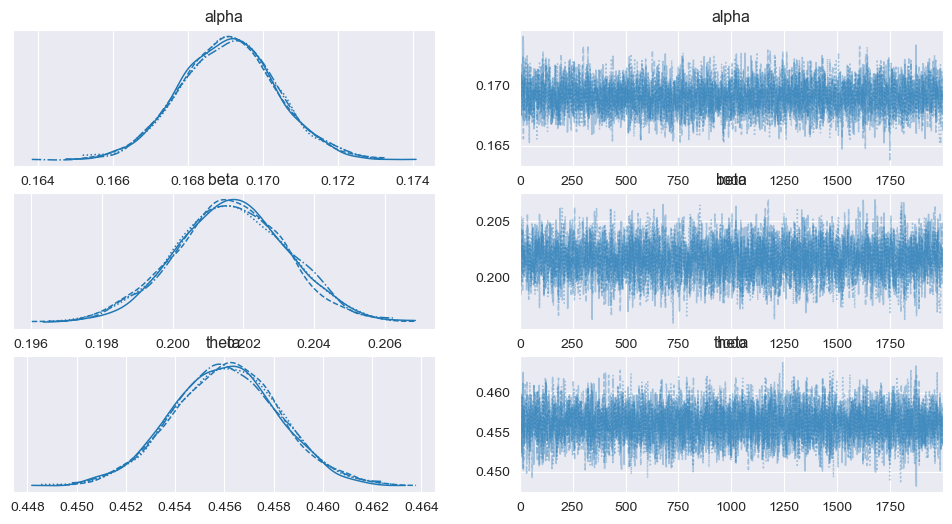

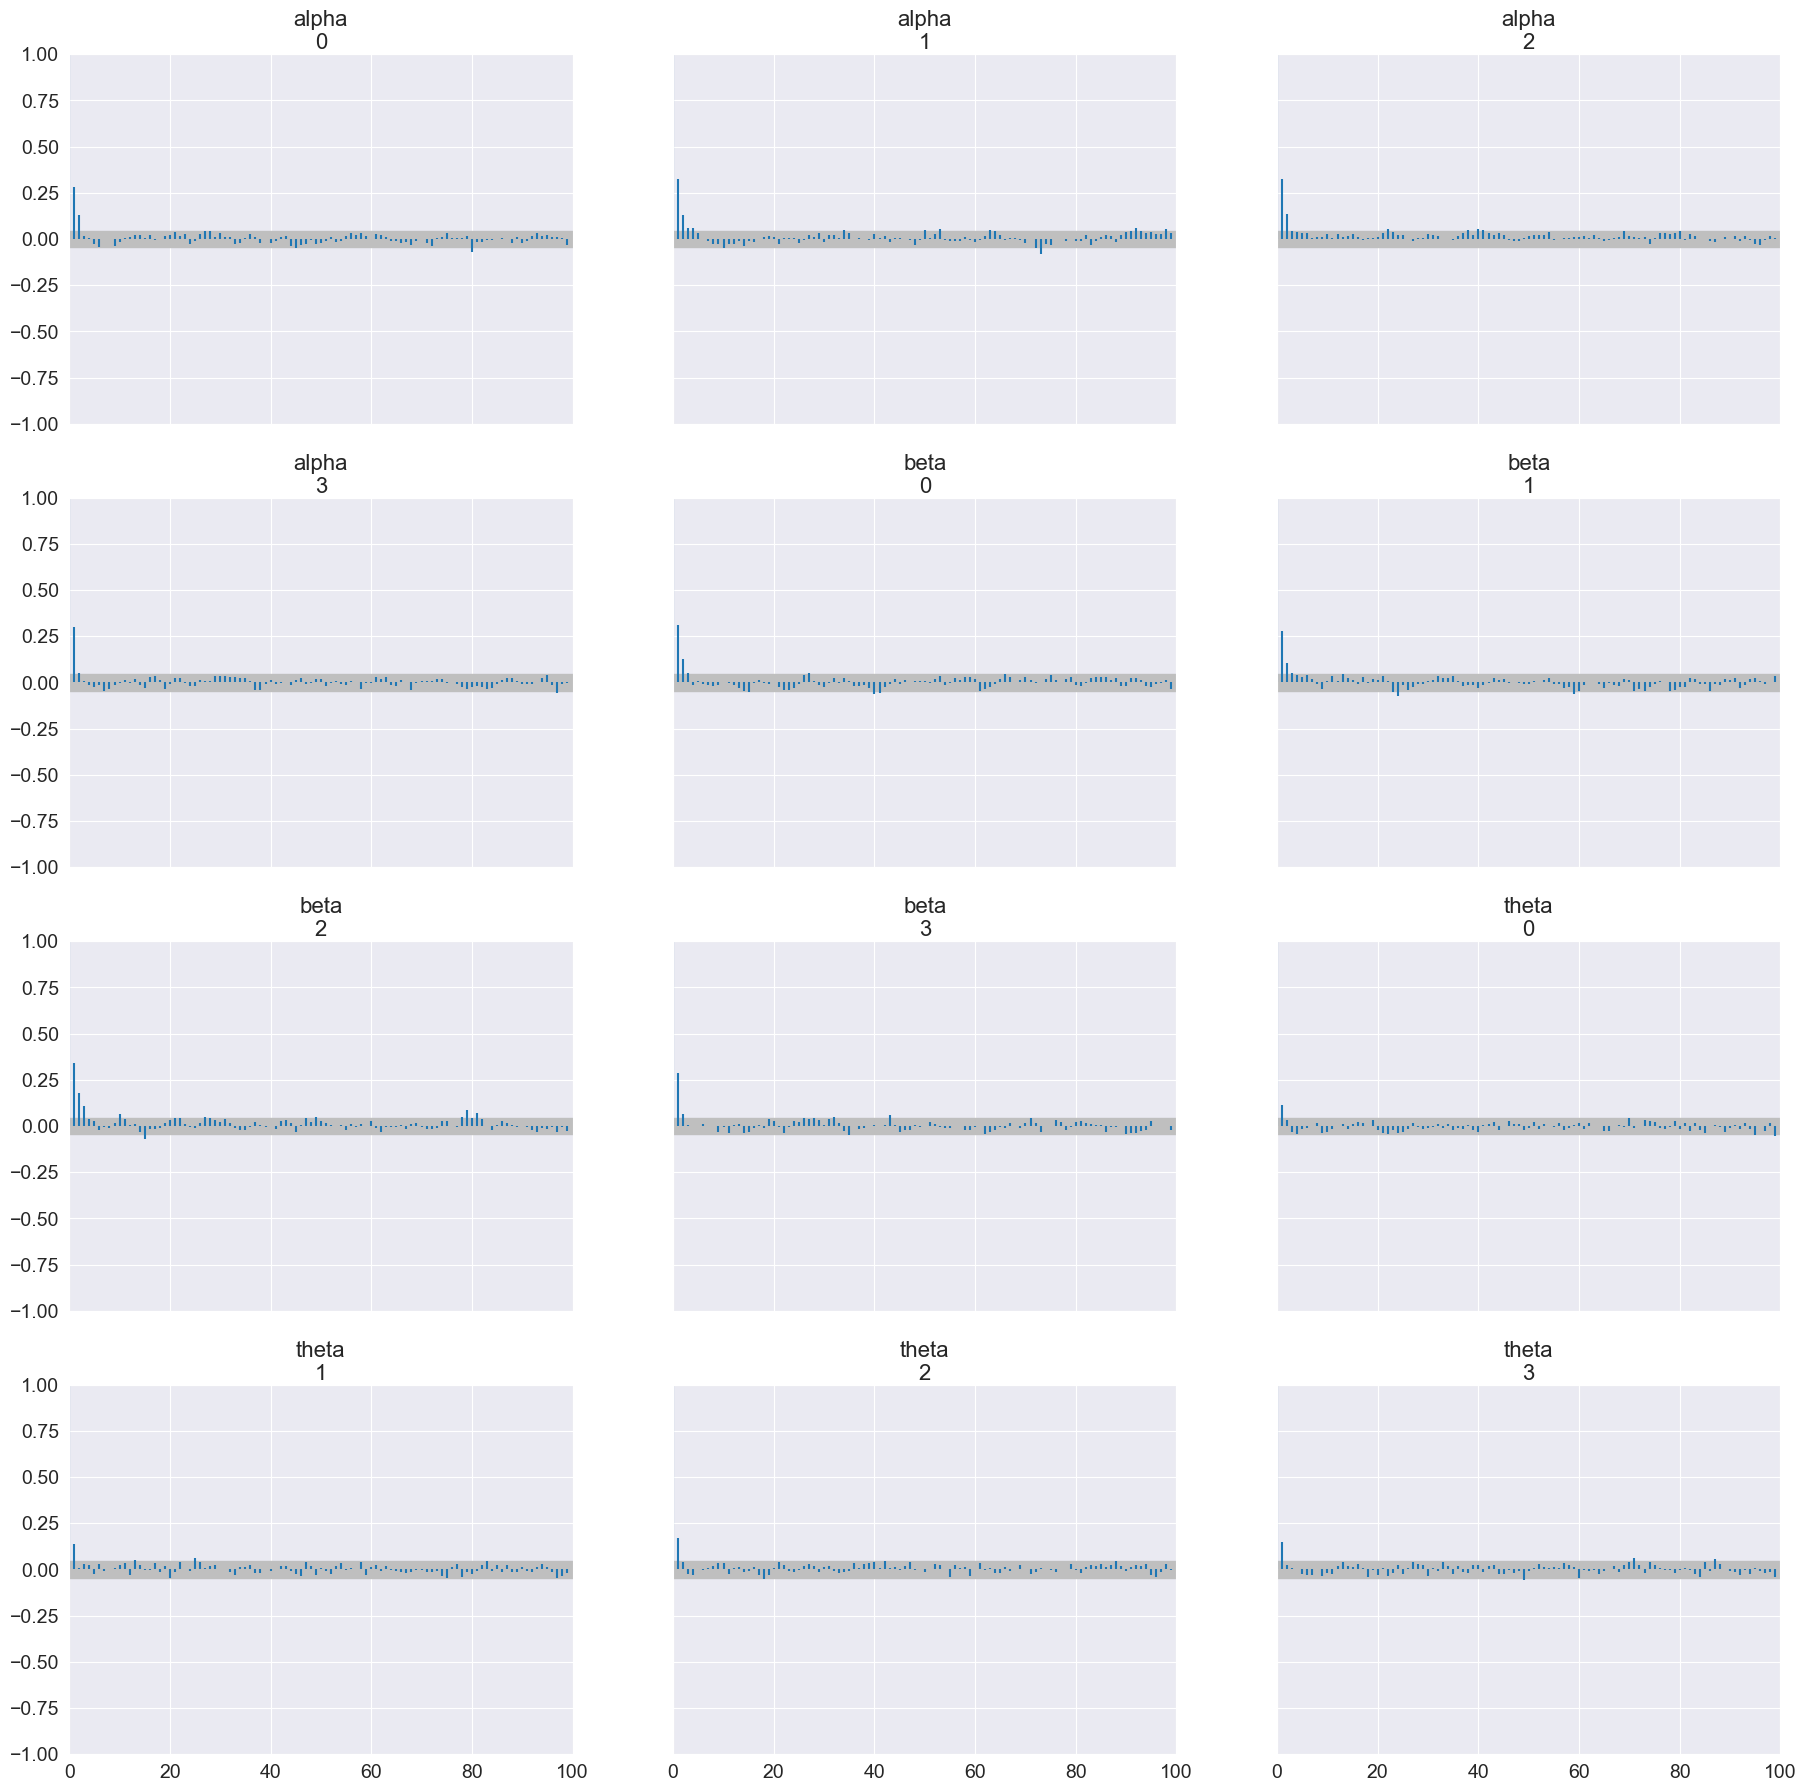

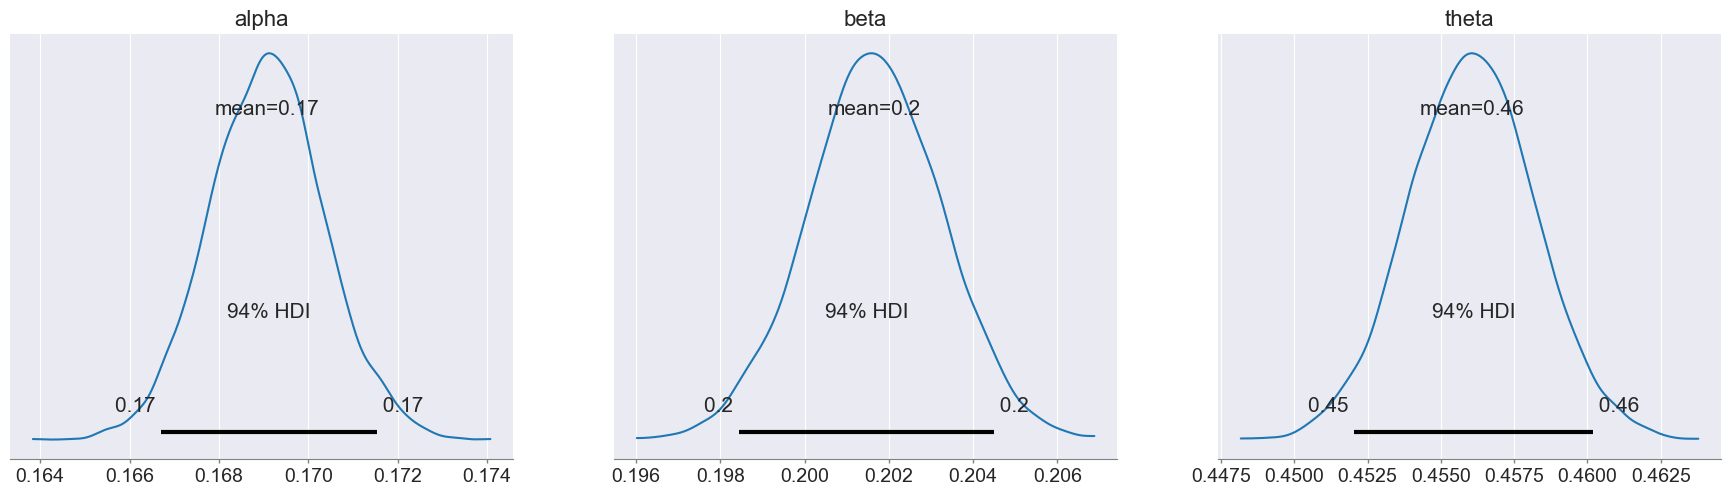

In [10]:
# Summarize the trace
summary = az.summary(trace, hdi_prob=0.95)
print(summary)

# Visualize the trace and posterior distributions
az.plot_trace(trace)
az.plot_autocorr(trace)
az.plot_posterior(trace)

In [11]:
# Extract the mean collaboration rate from the posterior distribution 
theta_mean = summary.loc['theta', 'mean']

# Sample collaboration rates from the posterior distribution
posterior_samples = trace.posterior.stack(samples=("chain", "draw"))
alpha_samples = posterior_samples['alpha'].values
beta_samples = posterior_samples['beta'].values

# Calculate the collaboration rate percentiles for each author
collaboration_rate_samples = np.random.beta(alpha_samples, beta_samples)
collaboration_rate_samples_sorted = np.sort(collaboration_rate_samples, axis=0)
percentiles = np.array([percentileofscore(collaboration_rate_samples_sorted, x) for x in df['COLLABORATION_RATE']])
df['COLLABORATION_RATE_PERCENTILE'] = percentiles

# Get more collaborative authors
df['IS_AUTHOR_MORE_COLLABORATIVE'] = df['COLLABORATION_RATE'] > theta_mean

In [12]:
import pandas as pd

# Query the author full names from DIM_AUTHOR table from BigQuery
query = f"""
SELECT
    A.AUTHOR_SID,
    A.AUTHOR_FULL_NAME,
    STRING_AGG(DISTINCT F.INSTITUTION_SID) AS INSTITUTIONS
FROM
    {schema}.FCT_COLLABORATION F
INNER JOIN 
    {schema}.DIM_AUTHOR A USING(AUTHOR_SID)
GROUP BY A.AUTHOR_SID, A.AUTHOR_FULL_NAME
"""
# Query the author full names
df_author = client.query(query).to_dataframe()

# Merge the top authors with their full names
authors = df.merge(df_author, on='AUTHOR_SID')
pd.set_option('display.max_rows', None)
# Only show authors working on institution UNI_LJ
authors[authors['INSTITUTIONS'].str.contains('UNI_LJ')].sort_values(by='COLLABORATION_RATE_PERCENTILE',
                                                                    ascending=False).head(100)

,AUTHOR_SID,PUBLICATIONS,EXTERNAL_COLLABORATIONS,COLLABORATION_RATE,COLLABORATION_RATE_PERCENTILE,IS_AUTHOR_MORE_COLLABORATIVE,AUTHOR_FULL_NAME,INSTITUTIONS
4812,559b8b2c410bd001b221c5208de2b8b1,14,14,0.999999,97.0625,True,Dušan D. Repovš,UNI_LJ
2696,7f223fcef7c4c49ccf719d50f660b727,11,11,0.999999,97.0625,True,Anja Oštrbenk,UNI_LJ
4890,1ea25a3de606684ab46e7f0f67ba43e2,18,18,0.999999,97.0625,True,Klemen Dovc,"UNI_LJ,Other"
13241,960a5dbfa9be83af88a0e0e06d33e6c0,11,11,0.999999,97.0625,True,Teo Delić,UNI_LJ
4954,38e5e08ad7d6b016a4925000f3060ac8,14,14,0.999999,97.0625,True,Miha Krofel,UNI_LJ
9755,cbf07da7d08fe12c9dfbc31a26da76bc,12,12,0.999999,97.0625,True,Matija Jezeršek,UNI_LJ
9258,fde6bc5b2d35cfc20c0dff7fc6d29d59,11,11,0.999999,97.0625,True,Robert Zorec,UNI_LJ
2793,d9120803dc18ba720b4e7611a4a88149,11,11,0.999999,97.0625,True,Grega Repovs,UNI_LJ
13134,0089fb0d2d104a85df920bba051e15e3,10,10,0.999999,97.0625,True,Matej Černe,UNI_LJ
5799,e0a8410c22f0bc3583c538db5ae5ec87,15,15,0.999999,97.0625,True,Boštjan Genorio,UNI_LJ


In [13]:
# Turn to lowercase
authors['AUTHOR_FULL_NAME_LOWER'] = authors['AUTHOR_FULL_NAME'].str.lower()
# Show authors with the last name 'zupan'
authors[authors['AUTHOR_FULL_NAME_LOWER'].str.contains('zupan')]

,AUTHOR_SID,PUBLICATIONS,EXTERNAL_COLLABORATIONS,COLLABORATION_RATE,COLLABORATION_RATE_PERCENTILE,IS_AUTHOR_MORE_COLLABORATIVE,AUTHOR_FULL_NAME,INSTITUTIONS,AUTHOR_FULL_NAME_LOWER
1745,abbde464317710581886a3b405b50c87,27,14,0.518519,54.9875,True,Maja Zupančič,"UNI_LJ,Other",maja zupančič
4405,977a411aaed69971a2fd8cd39533a94f,12,6,0.5,54.3875,True,Anže Zupanc,"Other,UNI_LJ",anže zupanc
6816,9d78467db8f71edf0853f66dd102fa0c,10,7,0.7,60.6625,True,Tatjana Lejko Zupanc,"Other,UNI_LJ",tatjana lejko zupanc
7945,676b85b1d5300255138cd8ccf34fdfec,14,6,0.428571,52.1875,False,Eva Zupanic,"Other,UNI_LJ",eva zupanic
10354,0517f1ec4ceacc10a83f7d1897643225,34,13,0.382353,50.9250,False,Blaž Zupan,"Other,UNI_LJ",blaž zupan
16719,940450e58e4a2cacc296ac442d1a194a,10,0,0.000001,5.3875,False,Vesna ZUPANC,Other,vesna zupanc
21370,aee5de524c55ee0b7572b6cec07db7d0,42,1,0.02381,30.3500,False,Jernej Zupančič,"Other,UNI_LJ",jernej zupančič
21462,735e3e19ac89a3bb0e2dae9c92423f11,29,1,0.034483,32.5500,False,Marko Zupan,"Other,UNI_LJ",marko zupan
21918,c5a6cf8802b4344e5099bbf31a86abc8,13,2,0.153846,42.2125,False,Vesna Zupanc,"Other,UNI_LJ",vesna zupanc
23714,11af466cfa35cdd80fa6a2d1305ddf96,11,4,0.363636,50.3750,False,Jure Zupan,"Other,UNI_LJ",jure zupan
